In [1]:
import random
import math
import numpy as np
from typing import Tuple


class MAB:
    def __init__(
            self, 
            n_arms, 
            prob_min: float, 
            prob_max: float):
        assert prob_min >= 0 and prob_max <= 1
        self.n_arms = n_arms
        self.arms_probs = np.random.uniform(low=prob_min, high=prob_max, size=n_arms)
        self.arms_selections = np.zeros(n_arms)
        self.arms_wins = np.zeros(n_arms)
        self.upper_confidence_boundaries = np.array([np.inf] * n_arms)
        self.score = 0


    def reset_scores(self):
        self.score = 0
        self.arms_selections = np.zeros(self.n_arms)


    def win_lose_update(self, arm_id: int) -> bool:
        self.arms_selections[arm_id] += 1
        win = random.random() > self.arms_probs[arm_id]
        if win:
            self.score += 1
            self.arms_wins[arm_id] += 1
        return win


    def strategy_random(self, arm_id: int) -> Tuple[int, bool]:
        win = self.win_lose_update(arm_id)
        return random.choice(seq=range(self.n_arms)), win        


    def strategy_win_stay_lose_shift(self, arm_id: int) -> Tuple[int, bool]:
        win = self.win_lose_update(arm_id)
        # win -> stay
        if win:
            new_arm_id = arm_id  
        # lose -> shift
        else:
            new_arm_id = arm_id + 1
            if arm_id == (len(self.arms_probs) - 1):
                new_arm_id = 0
        return new_arm_id, win
    

    def strategy_upper_confidence_bound(self, arm_id: int) -> Tuple[int, bool]:
        win = self.win_lose_update(arm_id)
        mean = self.arms_wins[arm_id] / self.arms_selections[arm_id]
        total_arm_pulls = self.arms_selections.sum()
        this_arm_pulls = self.arms_selections[arm_id]
        radicand = 2 * math.log(total_arm_pulls) / this_arm_pulls
        self.upper_confidence_boundaries[arm_id] = mean + math.sqrt(radicand)
        new_arm_id = int(np.argmax(self.upper_confidence_boundaries))
        return new_arm_id, win

In [2]:
import pandas as pd


def experiment(n_pulls: int, n_runs: int) -> pd.DataFrame:
    start_arm = 0
    scores_random = np.zeros(n_runs, dtype=int)
    scores_win_stay_lose_shift = np.zeros(n_runs, dtype=int)
    scores_upper_confidence_bound = np.zeros(n_runs, dtype=int)


    for run in range(n_runs):
        mab = MAB(n_arms=10, prob_min=0.3, prob_max=0.7)

        # random
        mab.reset_scores()
        next_arm = start_arm
        for _ in range(n_pulls):
            next_arm, _ = mab.strategy_random(arm_id=next_arm)
        scores_random[run] = mab.score

        # win stay lose shift 
        mab.reset_scores()
        next_arm = start_arm
        for _ in range(n_pulls):
            next_arm, _ = mab.strategy_win_stay_lose_shift(arm_id=next_arm)
        scores_win_stay_lose_shift[run] = mab.score

        # upper confidence bound 
        mab.reset_scores()
        next_arm = start_arm
        for _ in range(n_pulls):
            next_arm, _ = mab.strategy_upper_confidence_bound(arm_id=next_arm)
        scores_upper_confidence_bound[run] = mab.score

    df_eval = pd.DataFrame({"score_random": scores_random, "score_win_stay_lose_shift": scores_win_stay_lose_shift, "score_upper_confidence_bound": scores_upper_confidence_bound})
    df_eval["random > wsls"] = df_eval["score_random"] > df_eval["score_win_stay_lose_shift"]
    df_eval["random > ucb"] = df_eval["score_random"] > df_eval["score_upper_confidence_bound"]
    df_eval["random is best"] = df_eval["random > wsls"] & df_eval["random > ucb"]

    df_eval["wsls > random"] = df_eval["score_win_stay_lose_shift"] > df_eval["score_random"]
    df_eval["wsls > ucb"] = df_eval["score_win_stay_lose_shift"] > df_eval["score_upper_confidence_bound"]
    df_eval["wsls is best"] = df_eval["wsls > random"] & df_eval["wsls > ucb"]

    df_eval["ucb > random"] = df_eval["score_upper_confidence_bound"] > df_eval["score_random"]
    df_eval["ucb > wsls"] = df_eval["score_upper_confidence_bound"] > df_eval["score_win_stay_lose_shift"]
    df_eval["ucb is best"] = df_eval["ucb > random"] & df_eval["ucb > wsls"]
    return df_eval

In [3]:
# the more pull are performed, the better ucb outperforms its competitors

n_runs = 1_000
pull_settings = [5, 10, 20, 50, 100, 1_000, 10_000]
random_strategy = []
wsls_strategy = []
ucb_strategy = []
for n_pulls in pull_settings:
    df_eval = experiment(n_runs=n_runs, n_pulls=n_pulls)
    random_strategy.append(int(df_eval["random is best"].sum()) / n_runs)
    wsls_strategy.append(int(df_eval["wsls is best"].sum()) / n_runs)
    ucb_strategy.append(int(df_eval["ucb is best"].sum()) / n_runs)

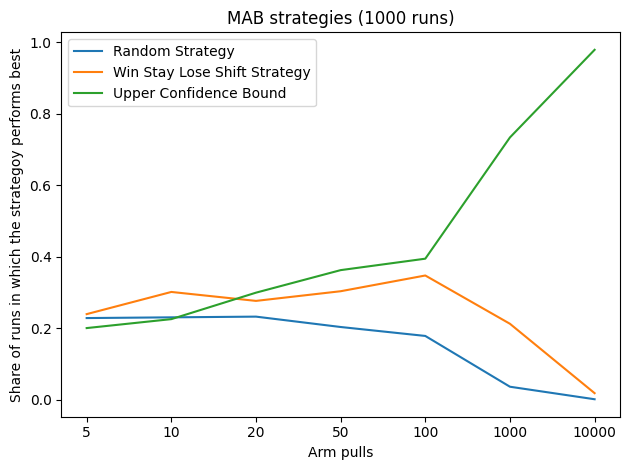

In [4]:
# plot results

import matplotlib.pyplot as plt


# Create x values for plotting
x = list(range(len(pull_settings)))

# Plot lines
plt.plot(x, random_strategy, label='Random Strategy')
plt.plot(x, wsls_strategy, label='Win Stay Lose Shift Strategy')
plt.plot(x, ucb_strategy, label='Upper Confidence Bound')

# Set xticks
plt.xticks(ticks=x, labels=pull_settings)

# Optional formatting
plt.xlabel('Arm pulls')
plt.ylabel('Share of runs in which the strategoy performs best')
plt.title('MAB strategies (1000 runs)')
plt.legend()
plt.tight_layout()
plt.show()
